# Computer Visions Jupyter Notebook

# Allie Garrison


In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
conn = sqlite3.connect('zippedData/im.db')

bom_movie_gross = pd.read_csv("zippedData/bom.movie_gross.csv")
rt_movie_info = pd.read_csv("zippedData/rt.movie_info.tsv", sep='\t')
rt_reviews = pd.read_csv('zippedData/rt.reviews.tsv', sep='\t',encoding='windows-1252')
tmdb_movies = pd.read_csv("zippedData/tmdb.movies.csv")
tn_movie_budgets = pd.read_csv("zippedData/tn.movie_budgets.csv", parse_dates=['release_date'])

In [3]:
## Making copy of movie budgets data frame for cleaning
tn_movie_budgets_clean = tn_movie_budgets.copy()

## turning the columns with dollar amounts into int types in millions of dollars
tn_movie_budgets_clean['production_budget_in_millions'] = tn_movie_budgets_clean['production_budget'].str.strip('$').str.replace(',', '')
tn_movie_budgets_clean['production_budget_in_millions'] = tn_movie_budgets_clean['production_budget_in_millions'].astype('int64') / 1000000

tn_movie_budgets_clean['domestic_gross_in_millions'] = tn_movie_budgets_clean['domestic_gross'].str.strip('$').str.replace(',', '')
tn_movie_budgets_clean['domestic_gross_in_millions'] = tn_movie_budgets_clean['domestic_gross_in_millions'].astype('int64') / 1000000

tn_movie_budgets_clean['worldwide_gross_in_millions'] = tn_movie_budgets_clean['worldwide_gross'].str.strip('$').str.replace(',', '')
tn_movie_budgets_clean['worldwide_gross_in_millions'] = tn_movie_budgets_clean['worldwide_gross_in_millions'].astype('int64') / 1000000

## taking out all movies that were released before January 1, 2010
tn_movie_budgets_clean = tn_movie_budgets_clean[tn_movie_budgets_clean['release_date'] >= "2010-01-01"]

## taking out all movies that did not make a profit
tn_movie_budgets_clean = tn_movie_budgets_clean[tn_movie_budgets_clean['domestic_gross_in_millions'] != 0]

In [4]:
## Creating columns with return on investment (ROI) for domestic and international revenue
tn_movie_budgets_clean['ROI_domestic'] = (tn_movie_budgets_clean['domestic_gross_in_millions'] / tn_movie_budgets_clean['production_budget_in_millions']) * 100
tn_movie_budgets_clean['ROI_international'] = (tn_movie_budgets_clean['worldwide_gross_in_millions'] / tn_movie_budgets_clean['production_budget_in_millions']) * 100

### 

In [5]:
## joining movie_basics and movie_ratings to create a data frame with title, runtime, genre, ratings, and votes
table_genre = pd.read_sql('''
SELECT mb.primary_title, 
        mb.runtime_minutes, 
        mb.genres, 
        mr.averagerating,
        mr.numvotes,
        mb.runtime_minutes
FROM movie_basics AS mb
JOIN movie_ratings AS mr USING (movie_id)
''', conn)

In [6]:
## merging the cleaned tn.movie_budgets dataframe with table_genre on movie title
genre_ratings_budget = tn_movie_budgets_clean.merge(table_genre, how='inner', left_on='movie', right_on='primary_title')

In [7]:
genre_ratings_budget.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,production_budget_in_millions,domestic_gross_in_millions,worldwide_gross_in_millions,ROI_domestic,ROI_international,primary_title,runtime_minutes,genres,averagerating,numvotes,runtime_minutes
0,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",410.6,241.063875,1045.663875,58.710150,254.667286,Pirates of the Caribbean: On Stranger Tides,136.0,"Action,Adventure,Fantasy",6.6,447624,136.0
1,3,2019-06-07,Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",350.0,42.762350,149.762350,12.217814,42.789243,Dark Phoenix,113.0,"Action,Adventure,Sci-Fi",6.0,24451,113.0
2,4,2015-05-01,Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",330.6,459.005868,1403.013963,138.840250,424.384139,Avengers: Age of Ultron,141.0,"Action,Adventure,Sci-Fi",7.3,665594,141.0
3,7,2018-04-27,Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,134,200",300.0,678.815482,2048.134200,226.271827,682.711400,Avengers: Infinity War,149.0,"Action,Adventure,Sci-Fi",8.5,670926,149.0
4,9,2017-11-17,Justice League,"$300,000,000","$229,024,295","$655,945,209",300.0,229.024295,655.945209,76.341432,218.648403,Justice League,120.0,"Action,Adventure,Fantasy",6.5,329135,120.0


# Cole Sussmeier

In [8]:
# create profit column
genre_ratings_budget['profit_in_millions'] = genre_ratings_budget['worldwide_gross_in_millions'] - genre_ratings_budget['production_budget_in_millions']

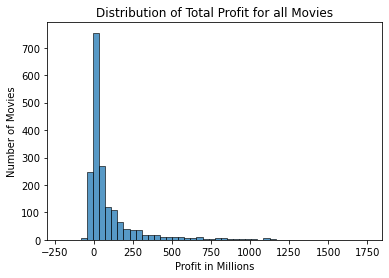

In [9]:
plt.title("Distribution of Total Profit for all Movies")
plt.xlabel("Profit in Millions")
plt.ylabel("Number of Movies")
sns.histplot(genre_ratings_budget['profit_in_millions'], bins=50);

In [10]:
# genre_hash is a dictionary where each key is a genre, and the value is the number of times it occurs in the 'genres' column
genre_hash = {}

# array of lists where each individual list is every genre listed for a single movie
genre_lists = genre_ratings_budget['genres'].str.split(',')

for i, genres in enumerate(genre_lists):
    # try/ except in case there is an empty list (no genres listed for a movie)
    try:
        for genre in genres:
            # add one to genre if the key exists
            if genre in genre_hash.keys():
                genre_hash[genre] += 1
            # otherwise create the key
            else:
                genre_hash[genre] = 1
    except:
        pass


In [11]:
genre_hash

{'Action': 466,
 'Adventure': 365,
 'Fantasy': 135,
 'Sci-Fi': 146,
 'Thriller': 314,
 'Western': 12,
 'Animation': 105,
 'Comedy': 558,
 'Family': 95,
 'Crime': 258,
 'Drama': 953,
 'Musical': 11,
 'Horror': 207,
 'Romance': 227,
 'Mystery': 144,
 'Documentary': 91,
 'Biography': 155,
 'History': 59,
 'Sport': 43,
 'War': 26,
 'Music': 57,
 'News': 2}

In [12]:
genre_stats = []
for genre in genre_hash.keys():
    #filter for every entry that contains the current genre
    mask = genre_ratings_budget[genre_ratings_budget['genres'].str.contains(genre) == True]
    # append list with averages for relevant features
    genre_stats.append([genre, mask['profit_in_millions'].mean().round(2), 
                        mask['production_budget_in_millions'].mean().round(2),
                        mask['averagerating'].mean().round(2),
                        mask['numvotes'].mean().round(2)])

In [13]:
#convert to dataframe
genre_stats_df = pd.DataFrame(genre_stats, 
                              columns=['Genre', 'Average_Profit', 'Average_Budget', 'Average_Rating', 'Average_Votes'])
genre_stats_df

,Genre,Average_Profit,Average_Budget,Average_Rating,Average_Votes
0,Action,160.90,79.93,6.33,173279.07
1,Adventure,241.02,105.76,6.49,195600.38
2,Fantasy,165.87,82.88,6.11,137905.34
3,Sci-Fi,236.87,88.97,6.49,258160.36
4,Thriller,82.10,34.26,6.05,105111.21
5,Western,46.35,50.07,6.78,165738.00
6,Animation,280.62,98.50,6.67,121386.85
7,Comedy,92.29,39.56,6.29,88686.08
8,Family,141.12,70.00,6.17,76245.96
9,Crime,50.29,32.38,6.39,106000.05


In [ ]:
# important note: There are many instances where genres overlap, ie Avengers Endgame is action and adventure.
# This means that the profit of this individual movie is factored into the averages for both genres 
# and they are not independent measures

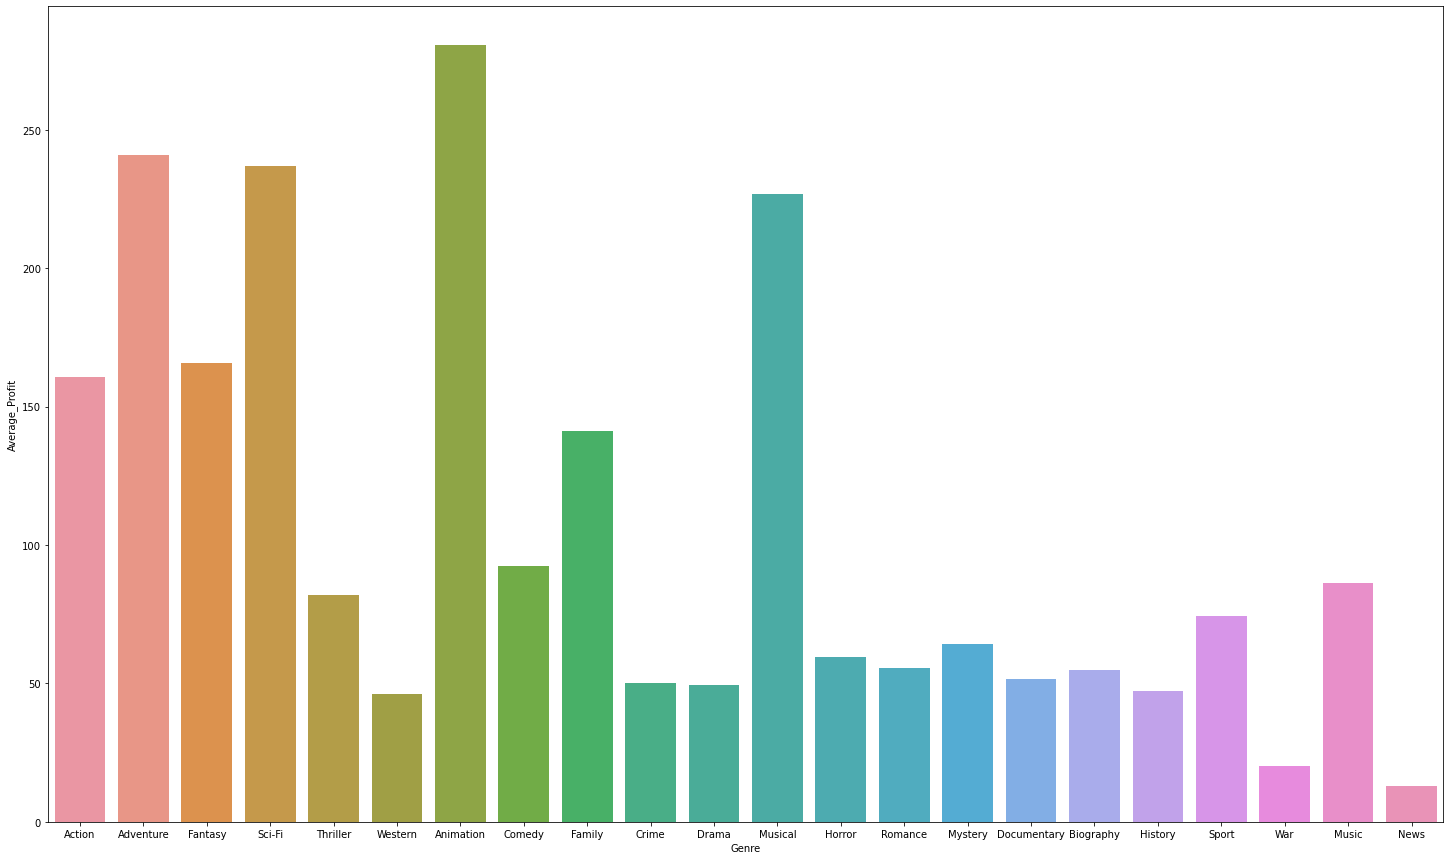

In [77]:
plt.figure(figsize=(25,15))
sns.barplot(data = genre_stats_df, x='Genre', y='Average_Profit');

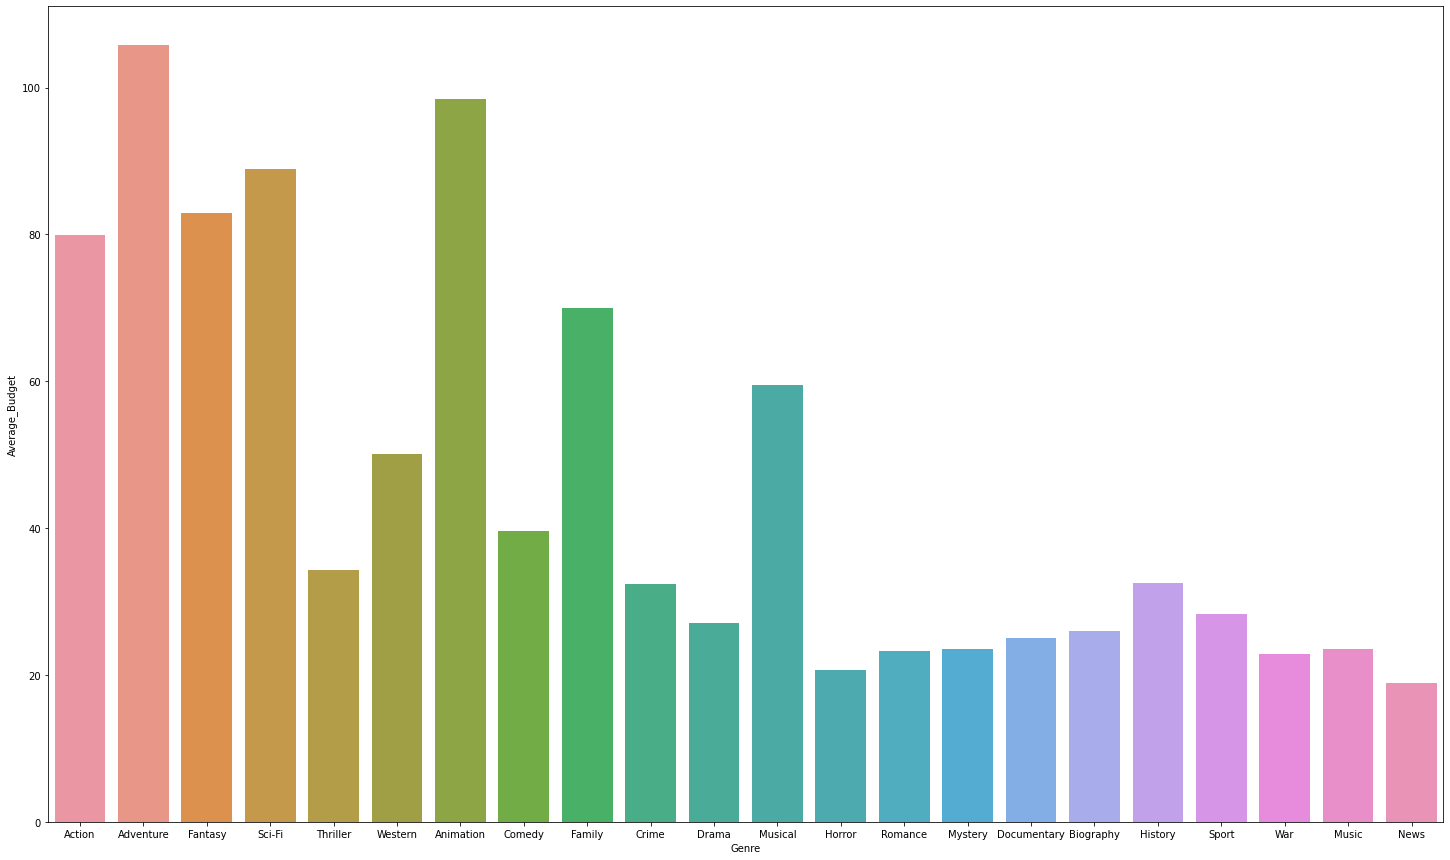

In [78]:
plt.figure(figsize=(25,15))
sns.barplot(data = genre_stats_df, x='Genre', y='Average_Budget');

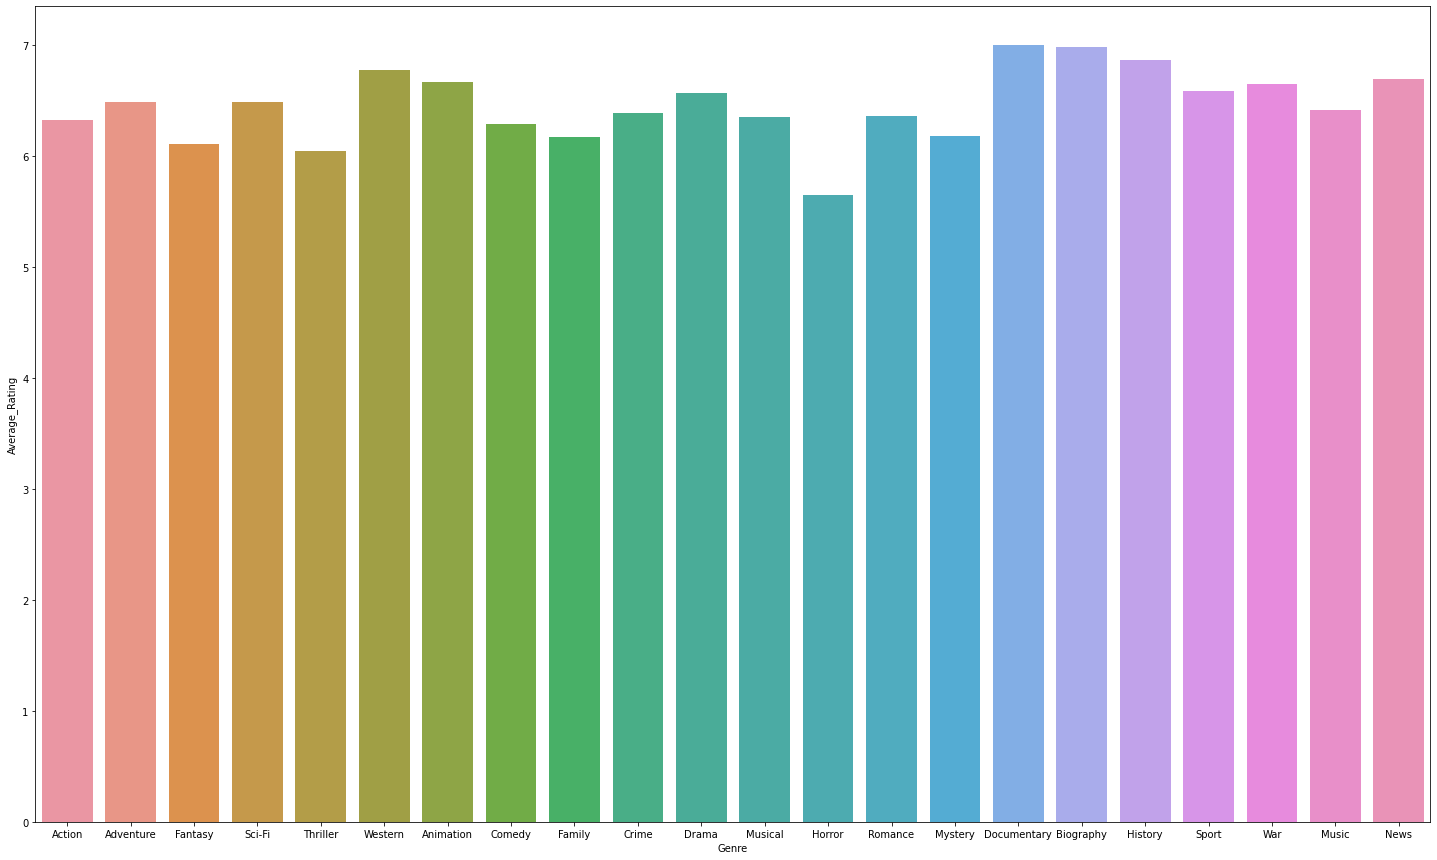

In [82]:
plt.figure(figsize=(25,15))
sns.barplot(data = genre_stats_df, x='Genre', y='Average_Rating');

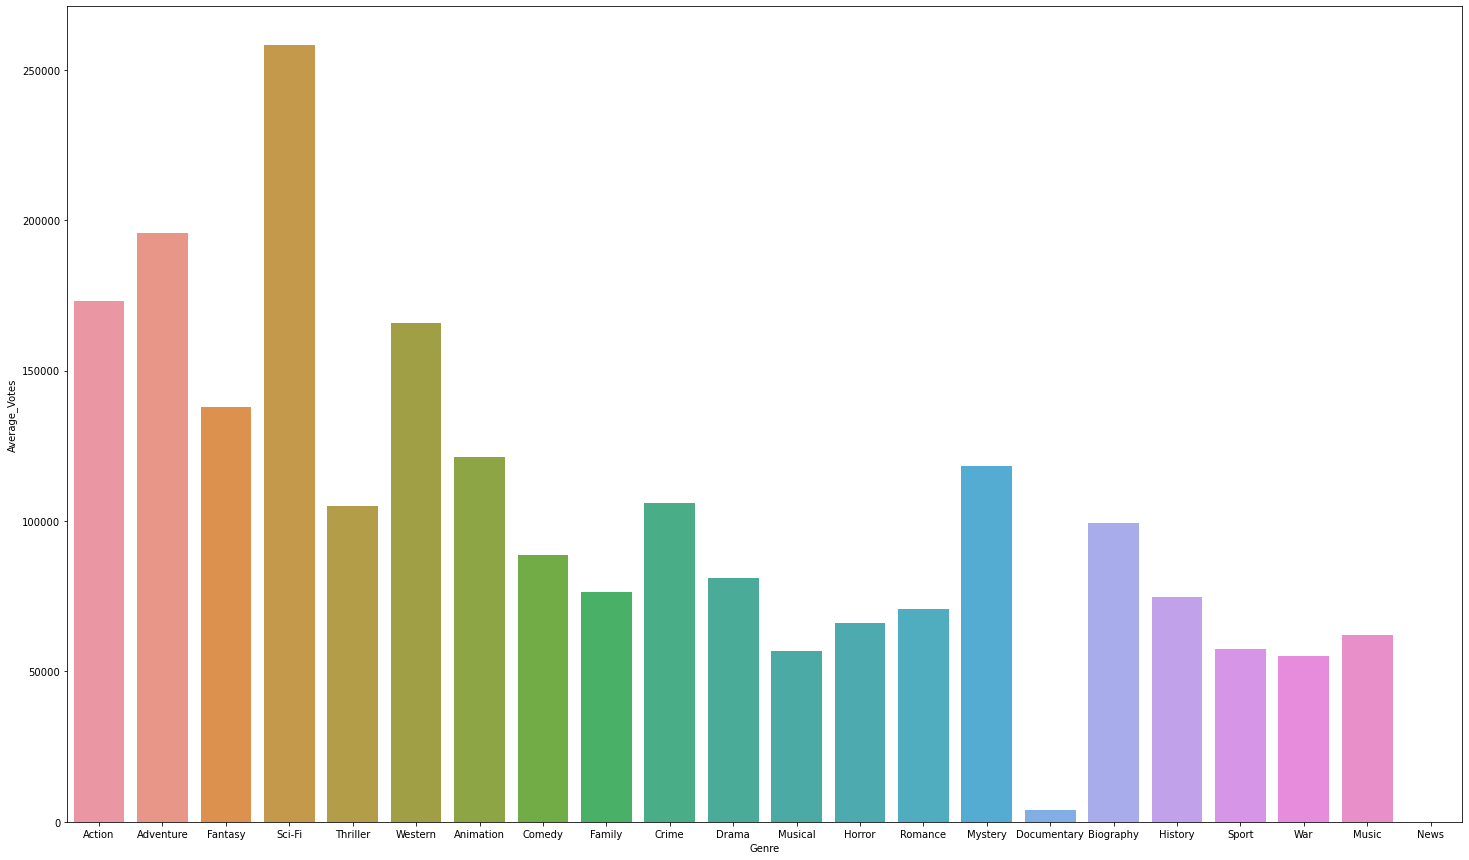

In [83]:
plt.figure(figsize=(25,15))
sns.barplot(data = genre_stats_df, x='Genre', y='Average_Votes');

In [84]:
genre_stats_df.corr()

,Average_Profit,Average_Budget,Average_Rating,Average_Votes
Average_Profit,1.000000,0.911674,-0.156521,0.585199
Average_Budget,0.911674,1.000000,-0.083593,0.716499
Average_Rating,-0.156521,-0.083593,1.000000,-0.133048
Average_Votes,0.585199,0.716499,-0.133048,1.000000


In [ ]:
# feel free to run any statistical tests that may be relevant to our reccomendations... this is just the outline required
# for a 1sample t-test

In [10]:
avg_profit = genre_ratings_budget['profit_in_millions'].mean()
print(avg_profit)

94.15790165165491


In [11]:
action = genre_ratings_budget[genre_ratings_budget['genres'].str.contains('Action') == True]

In [12]:
from scipy import stats

In [13]:
stats.ttest_1samp(action['profit_in_millions'], popmean=avg_profit)

Ttest_1sampResult(statistic=5.621600148484867, pvalue=3.2669437136587626e-08)

In [14]:
# avg profit from action is significantly different than avg profit overall

## Working Area 1

In [16]:
conn = sqlite3.connect("im.db")



pd.read_sql("""
SELECT *



FROM movie_rating



""",conn)

DatabaseError: Execution failed on sql '
SELECT *



FROM movie_rating



': no such table: movie_rating

In [4]:
conn = sqlite3.connect("im.db")



pd.read_sql("""
SELECT *



FROM principals



""",conn)
#checking principals for insights between actors and revenue

,movie_id,ordering,person_id,category,job,characters
0,tt0111414,1,nm0246005,actor,None,"[""The Man""]"
1,tt0111414,2,nm0398271,director,None,None
2,tt0111414,3,nm3739909,producer,producer,None
3,tt0323808,10,nm0059247,editor,None,None
4,tt0323808,1,nm3579312,actress,None,"[""Beth Boothby""]"
...,...,...,...,...,...,...
1028181,tt9692684,1,nm0186469,actor,None,"[""Ebenezer Scrooge""]"
1028182,tt9692684,2,nm4929530,self,None,"[""Herself"",""Regan""]"
1028183,tt9692684,3,nm10441594,director,None,None
1028184,tt9692684,4,nm6009913,writer,writer,None


In [5]:
conn = sqlite3.connect("im.db")



pd.read_sql("""
SELECT *



FROM directors



""",conn)
#checking directors to correlate to movie and then to revenue

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0462036,nm1940585
2,tt0835418,nm0151540
3,tt0835418,nm0151540
4,tt0878654,nm0089502
...,...,...
291169,tt8999974,nm10122357
291170,tt9001390,nm6711477
291171,tt9001494,nm10123242
291172,tt9001494,nm10123248


In [6]:
conn = sqlite3.connect("im.db")



pd.read_sql("""
SELECT *



FROM movie_basics



""",conn)
#exploring how to match movie id to title and then match that to revenue in other dataset

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,None


<h2> Working Area 2 - Cameron Narimanian

<h3> Number of Films Per Genre Since 2010

(0.0, 250000.0)

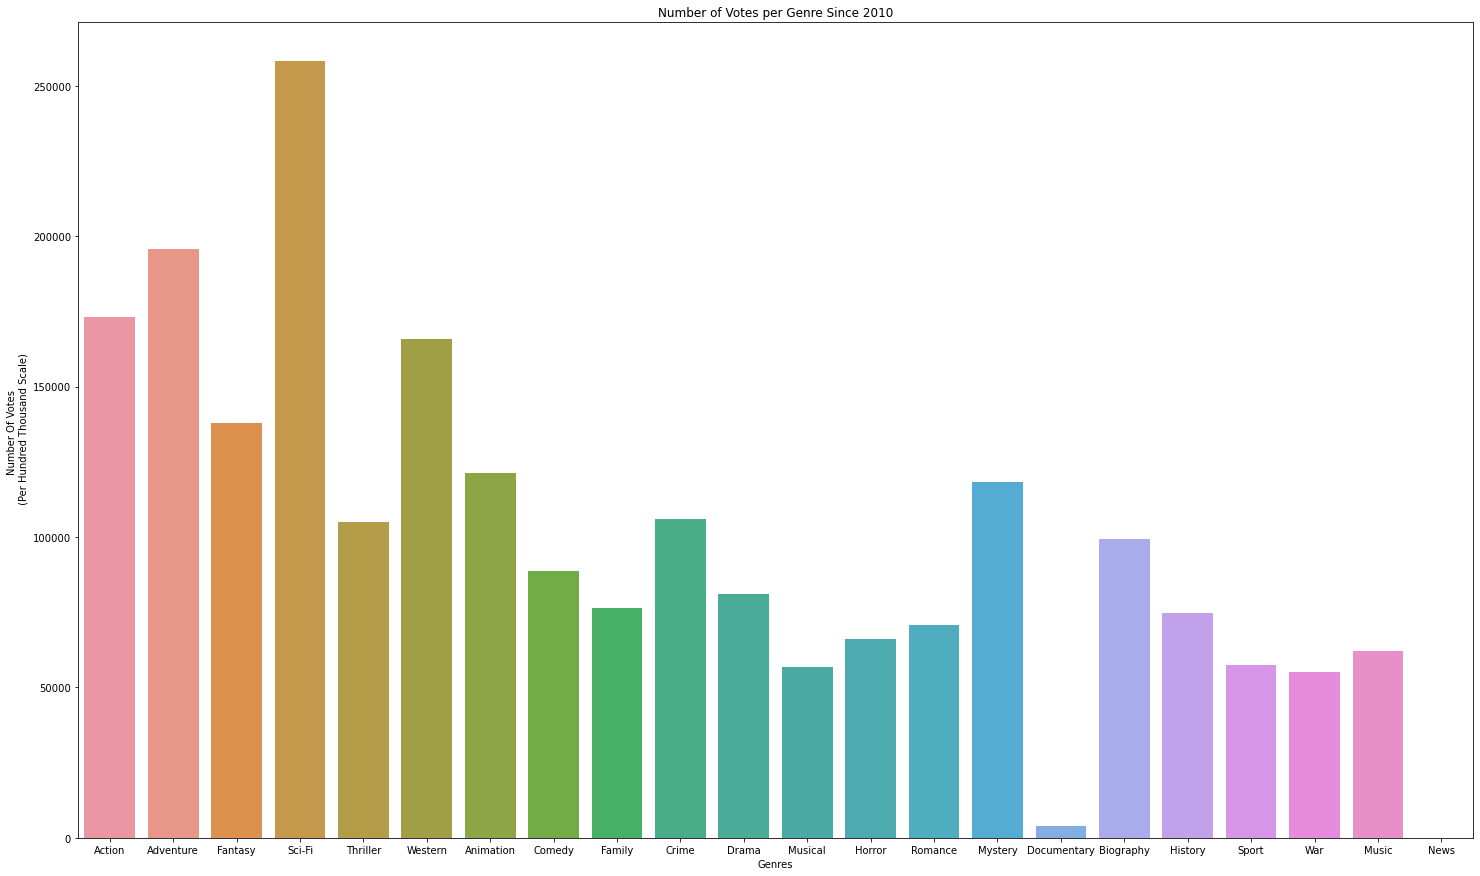

In [31]:
plt.figure(figsize=(25,15))
sns.barplot(data = genre_stats_df, x='Genre', y='Average_Votes')

plt.xlabel("Genres")
plt.ylabel("Number Of Votes \n (Per Hundred Thousand Scale)")
plt.title("Number of Votes per Genre Since 2010")
gfg.set_ylim(0,250000)

<h3> Average Ratings per Genre Since 2010

Text(0.5, 1.0, 'Average Ratings per Genre Since 2010')

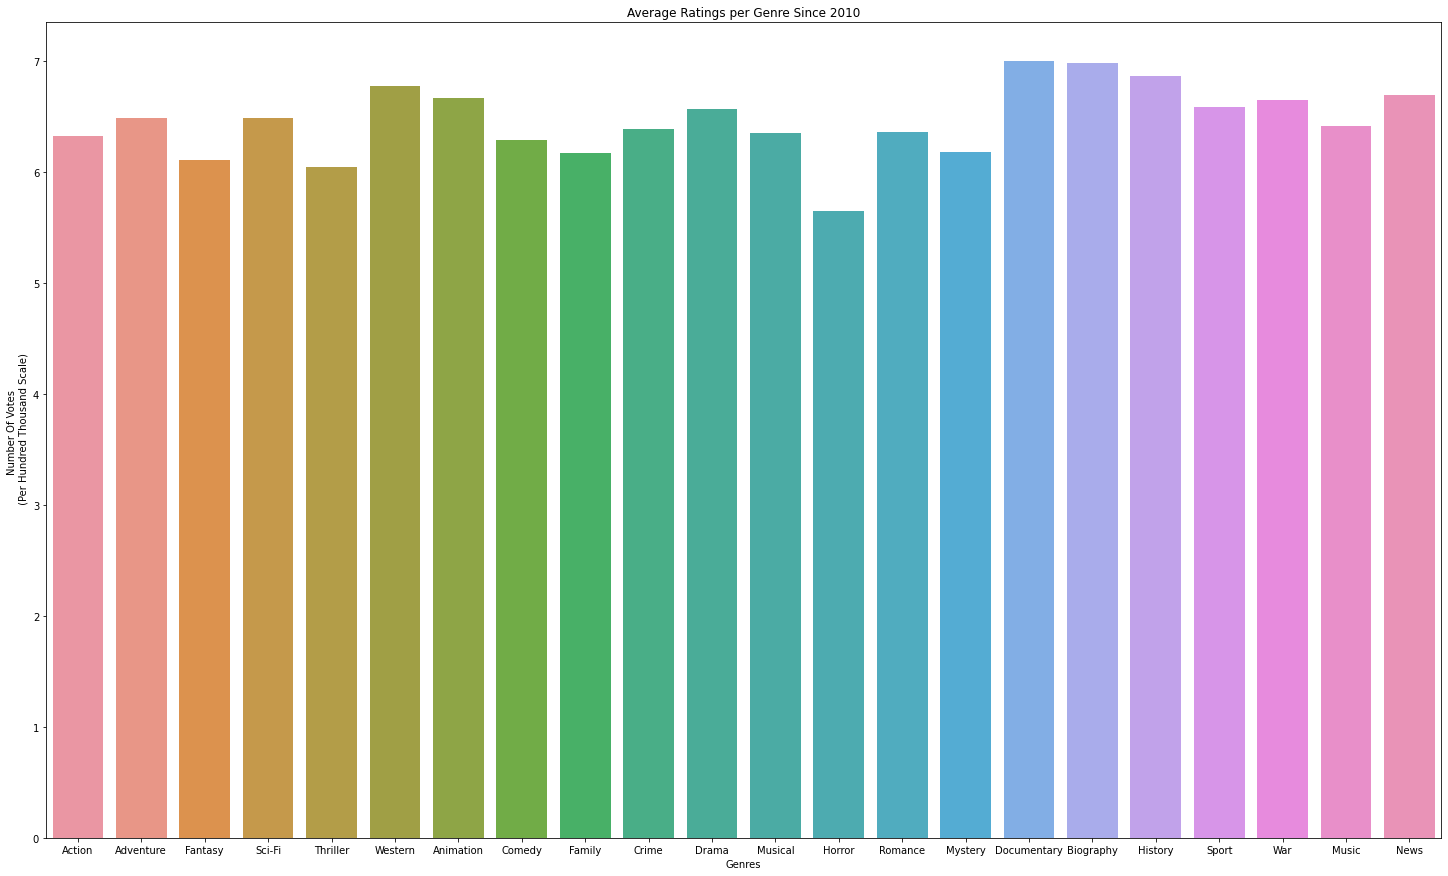

In [35]:
plt.figure(figsize=(25,15))
gfg = sns.barplot(data = genre_stats_df, x='Genre', y='Average_Rating')

plt.xlabel("Genres")
plt.ylabel("Number Of Votes \n (Per Hundred Thousand Scale)")
plt.title("Average Ratings per Genre Since 2010")


In [33]:
genre_ratings_budget

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,production_budget_in_millions,domestic_gross_in_millions,worldwide_gross_in_millions,ROI_domestic,ROI_international,primary_title,runtime_minutes,genres,averagerating,numvotes,runtime_minutes,profit_in_millions
0,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",410.600,241.063875,1045.663875,58.710150,254.667286,Pirates of the Caribbean: On Stranger Tides,136.0,"Action,Adventure,Fantasy",6.6,447624,136.0,635.063875
1,3,2019-06-07,Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",350.000,42.762350,149.762350,12.217814,42.789243,Dark Phoenix,113.0,"Action,Adventure,Sci-Fi",6.0,24451,113.0,-200.237650
2,4,2015-05-01,Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",330.600,459.005868,1403.013963,138.840250,424.384139,Avengers: Age of Ultron,141.0,"Action,Adventure,Sci-Fi",7.3,665594,141.0,1072.413963
3,7,2018-04-27,Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,134,200",300.000,678.815482,2048.134200,226.271827,682.711400,Avengers: Infinity War,149.0,"Action,Adventure,Sci-Fi",8.5,670926,149.0,1748.134200
4,9,2017-11-17,Justice League,"$300,000,000","$229,024,295","$655,945,209",300.000,229.024295,655.945209,76.341432,218.648403,Justice League,120.0,"Action,Adventure,Fantasy",6.5,329135,120.0,355.945209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1838,20,2015-07-31,Counting,"$50,000","$8,374","$8,374",0.050,0.008374,0.008374,16.748000,16.748000,Counting,111.0,Documentary,6.0,126,111.0,-0.041626
1839,32,2011-02-11,Raymond Did It,"$40,000","$3,632","$3,632",0.040,0.003632,0.003632,9.080000,9.080000,Raymond Did It,83.0,Horror,3.3,211,83.0,-0.036368
1840,38,2016-03-18,Krisha,"$30,000","$144,822","$144,822",0.030,0.144822,0.144822,482.740000,482.740000,Krisha,83.0,Drama,7.2,5917,83.0,0.114822
1841,45,2017-01-27,Emily,"$27,000","$3,547","$3,547",0.027,0.003547,0.003547,13.137037,13.137037,Emily,83.0,Drama,6.8,13,83.0,-0.023453


In [36]:
genre_stats_df

,Genre,Average_Profit,Average_Budget,Average_Rating,Average_Votes
0,Action,160.90,79.93,6.33,173279.07
1,Adventure,241.02,105.76,6.49,195600.38
2,Fantasy,165.87,82.88,6.11,137905.34
3,Sci-Fi,236.87,88.97,6.49,258160.36
4,Thriller,82.10,34.26,6.05,105111.21
5,Western,46.35,50.07,6.78,165738.00
6,Animation,280.62,98.50,6.67,121386.85
7,Comedy,92.29,39.56,6.29,88686.08
8,Family,141.12,70.00,6.17,76245.96
9,Crime,50.29,32.38,6.39,106000.05


<h4> Determine a relationship between Average Budget vs Average Profit for movies by genre since 2010

Text(0.5, 1.0, 'Average Budget vs Profit per Genre of Movies since 2010')

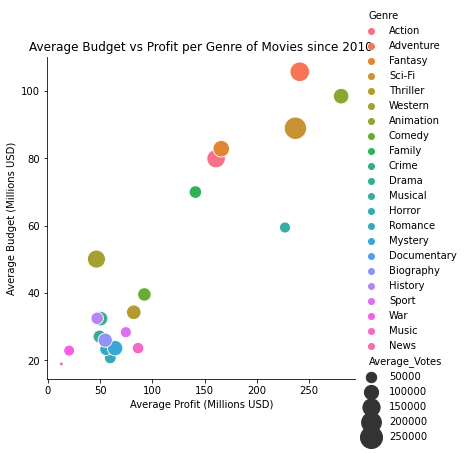

In [47]:
sns.relplot(data= genre_stats_df, x = "Average_Profit", y="Average_Budget",hue = "Genre", size = "Average_Votes", sizes = (15,500))

plt.xlabel("Average Profit (Millions USD)")
plt.ylabel("Average Budget (Millions USD)")
plt.title("Average Budget vs Profit per Genre of Movies since 2010")

## Working Area 3